<a href="https://colab.research.google.com/github/tomunizua/formative1-sound_clustering/blob/main/Theodora_Omunizua_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [7]:

#Make all Necessary Imports

# Audio processing
import librosa
import librosa.display

# Data handling
import zipfile
import numpy as np
import pandas as pd
import os
import glob

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering
from sklearn.cluster import KMeans, DBSCAN

# Evaluation Metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

# Load the Data
zip_file_path = '/content/drive/MyDrive/unlabelled_sounds.zip'
extraction_base_path = '/content/unlabelled_sounds_extracted/'

# folder from the zip that contains the sound files
subfolder_name = 'unlabelled_sounds'
unlabelled_data_path = os.path.join(extraction_base_path, subfolder_name)

# Ensure the base extraction path exists
os.makedirs(extraction_base_path, exist_ok=True)

# Unzip the Dataset
print(f"Attempting to extract {zip_file_path} to {extraction_base_path}...")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_base_path)
    print("Extraction complete. Files are in:", extraction_base_path)

# Extract Features

def extract_mel_features(file_path, sr=22050, n_mels=128, hop_length=512):
    """
    Extracts Mel Spectrogram features from an audio file.
    Takes the mean across the time axis to get a fixed-size feature vector.
    """
    try:
        y, sr = librosa.load(file_path, sr=sr)
        # Handle very short audio files that might cause issues with melspectrogram
        if len(y) < hop_length:
            print(f"Warning: Audio file {os.path.basename(file_path)} is too short. Skipping.")
            return None

        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_features = np.mean(mel_spectrogram, axis=1) # Average over time for a fixed-size vector per file
        return mel_features
    except Exception as e:
        print(f"Error processing {os.path.basename(file_path)}: {e}")
        return None # Return None for files that failed to process

features = [] # store the extracted feature vectors
file_paths = [] # Keep track of file paths for reference

print(f"\nStarting feature extraction")
audio_files_found = 0
# List all files in the determined data path
for root, _, files in os.walk(unlabelled_data_path):
    for file in files:
        if file.lower().endswith(('.wav', '.mp3', '.flac', '.ogg')):
            full_file_path = os.path.join(root, file)
            audio_files_found += 1
            feature_vector = extract_mel_features(full_file_path)
            if feature_vector is not None:
                features.append(feature_vector)
                file_paths.append(full_file_path) # Store path of successfully processed files
            else:
                print(f"Skipping {file} due to processing error.")

if not features:
    print(f"No audio features could be extracted from '{unlabelled_data_path}'. Please check the directory content and file formats.")
    X = np.array([]) # Initialize X as empty array to prevent errors later
else:
    X = np.array(features)
    print(f"\nSuccessfully extracted features from {len(features)} out of {audio_files_found} total audio files found.")
    print(f"Shape of the final feature matrix (X): {X.shape}")


Attempting to extract /content/drive/MyDrive/unlabelled_sounds.zip to /content/unlabelled_sounds_extracted/...
Extraction complete. Files are in: /content/unlabelled_sounds_extracted/

Starting feature extraction

Successfully extracted features from 3000 out of 3000 total audio files found.
Shape of the final feature matrix (X): (3000, 128)


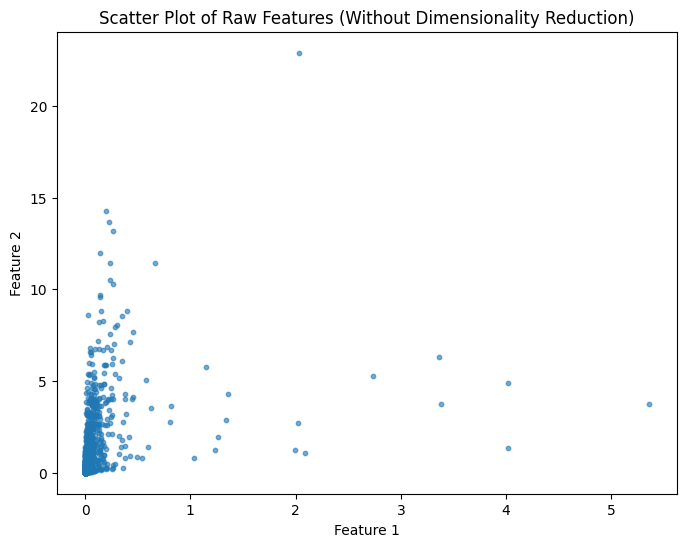

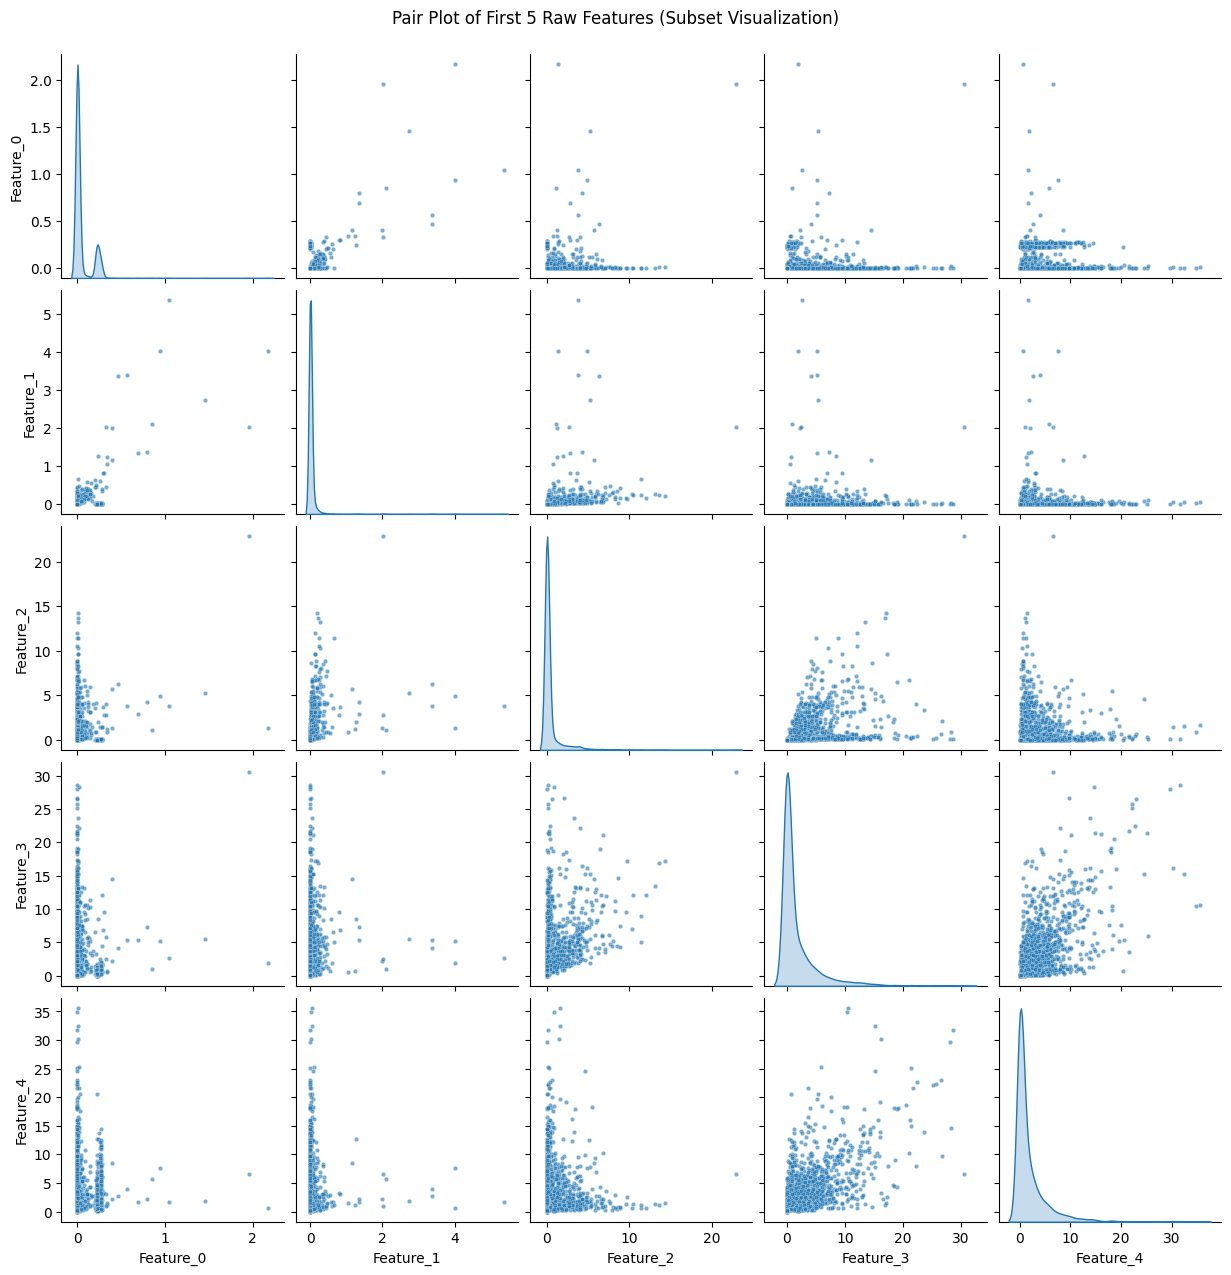

In [4]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(X[:, 1], X[:, 2], alpha=0.6, s=10)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
num_features_to_plot = min(5, X.shape[1])
feature_columns = [f"Feature_{i}" for i in range(num_features_to_plot)]
df = pd.DataFrame(X[:, :num_features_to_plot], columns=feature_columns)
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 10}) # diag_kind='kde' for density plots on diagonal
plt.suptitle(f"Pair Plot of First {num_features_to_plot} Raw Features (Subset Visualization)", y=1.02)
plt.show()


### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)

When Ifirst tried to visualize the raw Mel Spectrogram features, the plots were messy, overlapping and visually noisy, making it hard to see any structure or clusters. The high number of dimensions made the data difficult to interpret in 2D or 3D. Dimensionality reduction is necessary so we are able to transform the data into a lower-dimensional space while preserving its most important patterns, making it easier to visualize and improve the clustering results.


Shape after PCA: (3000, 3)
PCA Explained Variance Ratio (per component): [0.29712933 0.11746393 0.09135269]
Total Variance Explained by 3 PCA components: 0.51


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Shape after t-SNE: (3000, 3)

Generating 3D visualizations...


/tmp/ipython-input-6-130869581.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
/tmp/ipython-input-6-130869581.py:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2],


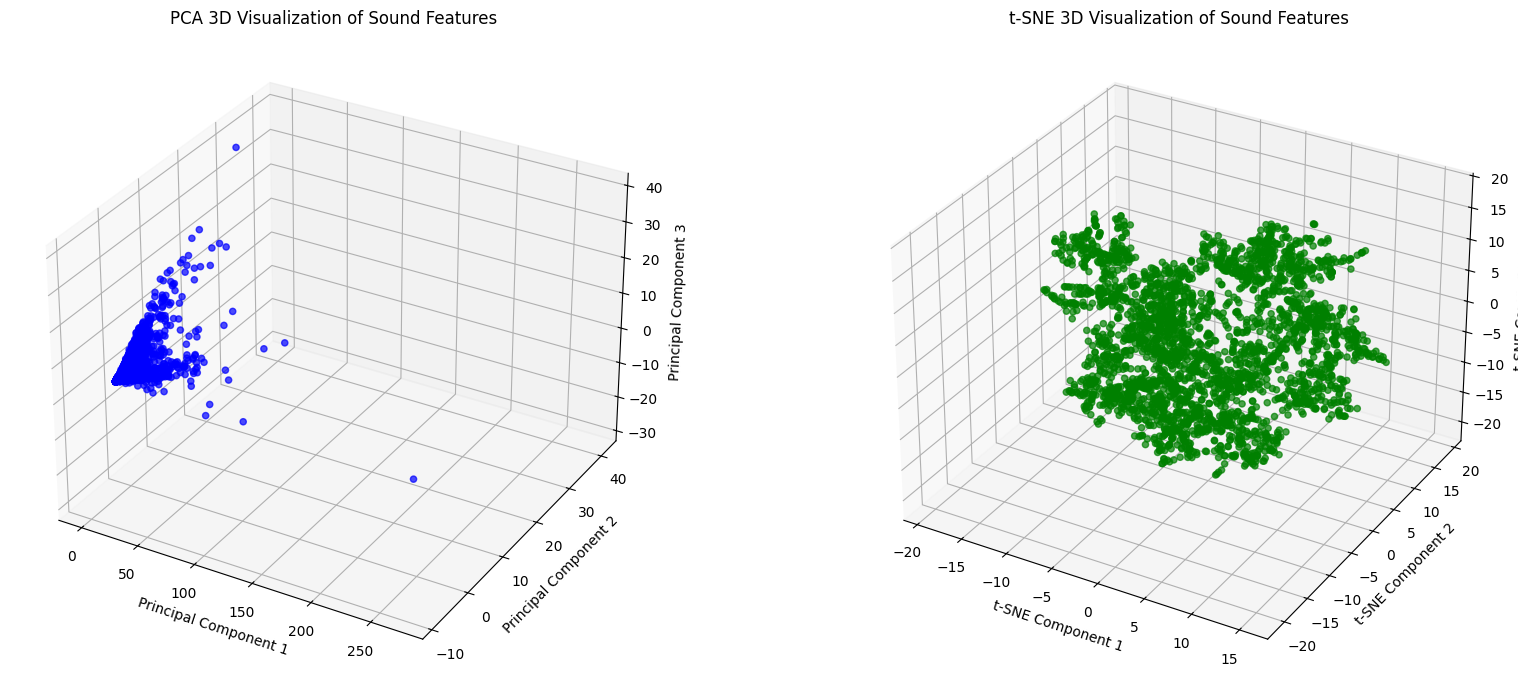

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Apply PCA (3 components) ---
pca = PCA(n_components=3, random_state=42) # Added random_state for reproducibility
features_pca = pca.fit_transform(X_scaled)
print(f"Shape after PCA: {features_pca.shape}")
print(f"PCA Explained Variance Ratio (per component): {pca.explained_variance_ratio_}")

# --- Apply t-SNE (3 components) ---
tsne = TSNE(n_components=3, random_state=42, n_iter=1000, learning_rate='auto', init='random')
features_tsne = tsne.fit_transform(X_scaled)
print(f"Shape after t-SNE: {features_tsne.shape}")

# 3D Visualization goes here
print("\nGenerating 3D visualizations...")
fig = plt.figure(figsize=(18, 7))

# PCA 3D Plot
ax1 = fig.add_subplot(121, projection='3d') # 1 row, 2 columns, 1st plot
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2],
                c='blue', cmap='viridis', s=20, alpha=0.7)
ax1.set_title('PCA 3D Visualization of Sound Features')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
ax1.grid(True)


# t-SNE 3D Plot
ax2 = fig.add_subplot(122, projection='3d') # 1 row, 2 columns, 2nd plot
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2],
                c='green', cmap='viridis', s=20, alpha=0.7)
ax2.set_title('t-SNE 3D Visualization of Sound Features')
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.set_zlabel('t-SNE Component 3')
ax2.grid(True)

plt.tight_layout()
plt.show()



### Which method (PCA or t-SNE) provides better separability of clusters and why?
The t-SNE plot showed more separated groupings, while the PCA plot had more overlapping clusters. t-SNE provides better separability of clusters because it is a non-linear technique designed to focus on local relationships, which allows it to easily find and show natural groupings. PCA on the other hand, is a linear method and focuses more on overall data spread and global variance.

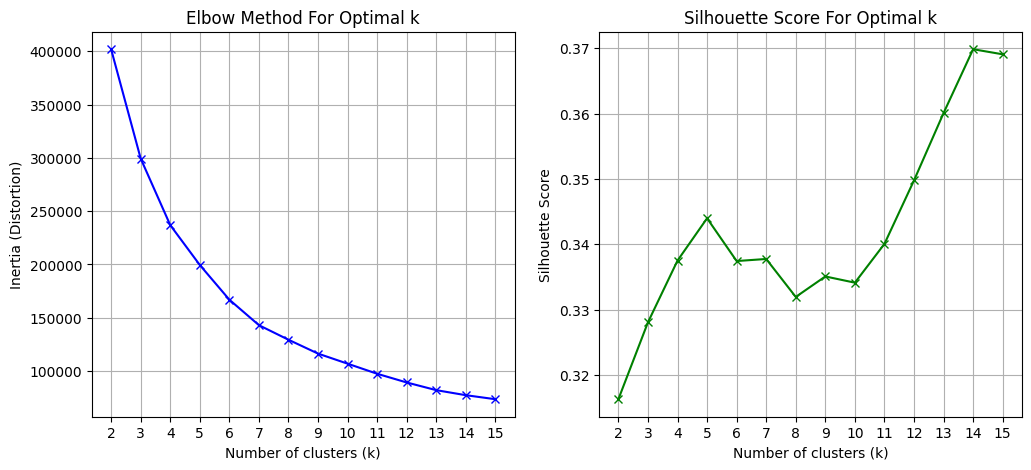

In [8]:

# Optimize number of clusters using Elbow Method

features_array = features_tsne # Using t-SNE for clustering

distortions = [] # Inertia
silhouette_scores = []
# Test k from 2 up to a reasonable number (e.g., min of 15 or number of samples - 1)
k_max = min(15, features_array.shape[0] - 1)
k_range = range(2, k_max + 1) # Ensure k_max is inclusive

if k_max < 2:
    print("Warning: Not enough samples to test multiple K values for KMeans optimization. Skipping optimization plots.")
    optimal_k = 2 if features_array.shape[0] >= 2 else 1 # Default if few samples
else:
    for k in k_range:
        kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans_model.fit(features_array)
        distortions.append(kmeans_model.inertia_)
        try:
            score = silhouette_score(features_array, kmeans_model.labels_)
            silhouette_scores.append(score)
        except ValueError: # Catches cases where only one cluster is formed or too few samples
            silhouette_scores.append(0) # Assign 0 if score cannot be computed

    # Plot Elbow Method and Silhouette Score
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.plot(k_range, distortions, 'bx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (Distortion)')
    plt.title('Elbow Method For Optimal k')
    plt.xticks(list(k_range))
    plt.grid(True)

    plt.subplot(122)
    plt.plot(k_range, silhouette_scores, 'gx-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score For Optimal k')
    plt.xticks(list(k_range))
    plt.grid(True)
    plt.show()


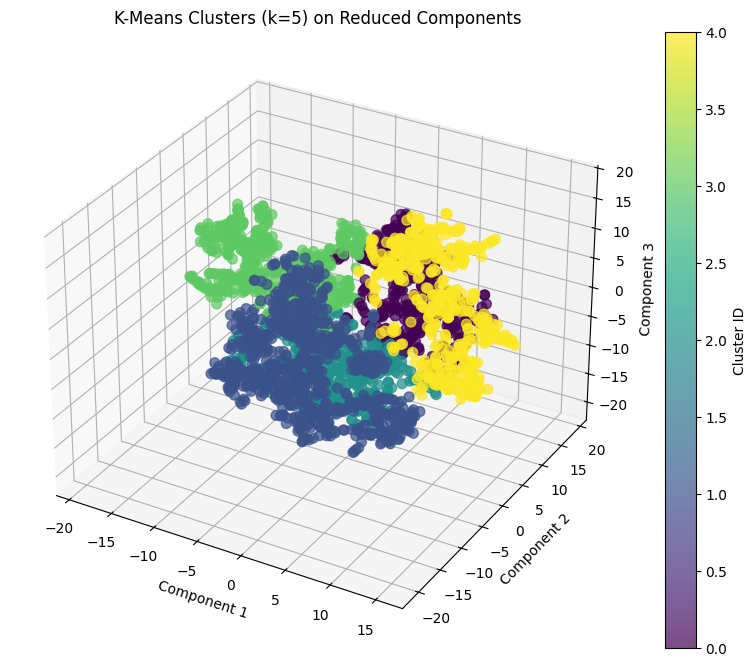

/tmp/ipython-input-13-70220062.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Spectral', len(unique_dbscan_labels))


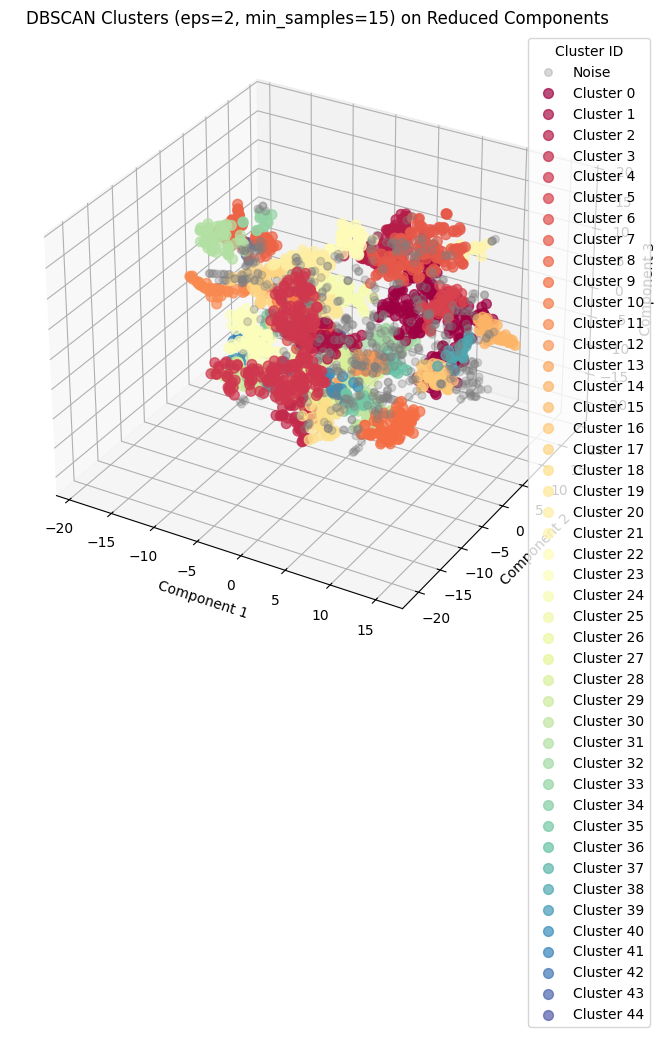

In [13]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=2, min_samples=15)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
fig_kmeans = plt.figure(figsize=(10, 8))
ax_kmeans = fig_kmeans.add_subplot(111, projection='3d')
scatter_kmeans = ax_kmeans.scatter(features_array[:, 0],
                                   features_array[:, 1],
                                   features_array[:, 2],
                                   c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
ax_kmeans.set_title(f'K-Means Clusters (k={optimal_k}) on Reduced Components')
ax_kmeans.set_xlabel('Component 1')
ax_kmeans.set_ylabel('Component 2')
ax_kmeans.set_zlabel('Component 3')
plt.colorbar(scatter_kmeans, label='Cluster ID')
plt.grid(True)
plt.show()

# Scatter Plot for DBSCAN Clusters
fig_dbscan = plt.figure(figsize=(10, 8))
ax_dbscan = fig_dbscan.add_subplot(111, projection='3d')

# Handle noise points for DBSCAN visualization
unique_dbscan_labels = np.unique(dbscan_labels)
colors = plt.cm.get_cmap('Spectral', len(unique_dbscan_labels))

for i, label in enumerate(unique_dbscan_labels):
    if label == -1:
        ax_dbscan.scatter(features_array[dbscan_labels == label, 0],
                          features_array[dbscan_labels == label, 1],
                          features_array[dbscan_labels == label, 2],
                          color='gray', s=30, alpha=0.3, label='Noise')
    else: # Actual clusters
        ax_dbscan.scatter(features_array[dbscan_labels == label, 0],
                          features_array[dbscan_labels == label, 1],
                          features_array[dbscan_labels == label, 2],
                          color=colors(label), s=50, alpha=0.7, label=f'Cluster {label}')

ax_dbscan.set_title(f'DBSCAN Clusters (eps=2, min_samples=15) on Reduced Components')
ax_dbscan.set_xlabel('Component 1')
ax_dbscan.set_ylabel('Component 2')
ax_dbscan.set_zlabel('Component 3')
plt.legend(title='Cluster ID', loc='best', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.show()



In [14]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

# Filter out noise points (-1 label) for metric calculation
non_noise_indices = dbscan_labels != -1
# Get unique cluster labels, excluding -1 (noise)
unique_dbscan_clusters = np.unique(dbscan_labels[non_noise_indices])

if len(unique_dbscan_clusters) >= 2:
    dbscan_silhouette = silhouette_score(features_array[non_noise_indices], dbscan_labels[non_noise_indices])
    dbscan_db_index = davies_bouldin_score(features_array[non_noise_indices], dbscan_labels[non_noise_indices])
else:
    # If fewer than 2 clusters (excluding noise) are found, metrics are not well-defined
    dbscan_silhouette = None
    dbscan_db_index = None

# --- Print Results ---
print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters")


K-Means - Silhouette Score: 0.3440, Davies-Bouldin Index: 1.0063
DBSCAN - Silhouette Score: 0.3547, Davies-Bouldin Index: 0.7869


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

After selecting k=5 as the optimal k through the lebow method, and testing different eps and min_samples, DBSCAN outperformed K-Means in both metrics, achieving a higher Silhouette Score (0.3547 vs 0.3440) and a lower Davies-Bouldin Index (0.7869 vs 1.0063), indicating better-defined and more compact clusters. This suggests that DBSCAN handled the data structure more effectively, likely due to its ability to detect clusters of different shapes and sizes. K-Means seems to  have struggled with the non-linear patterns as it prefers more regular, round clusters.


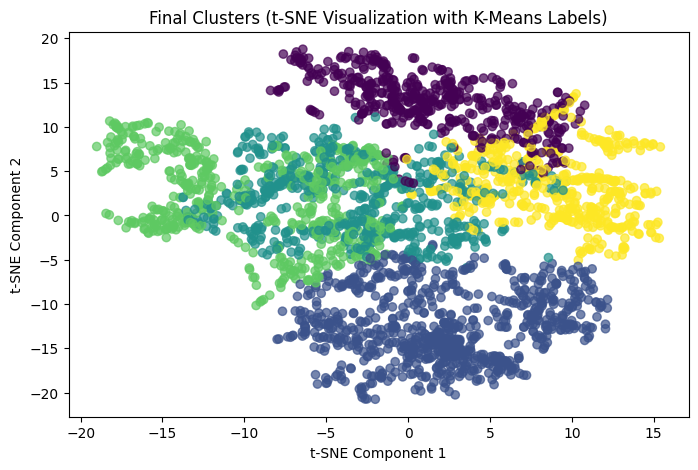

In [15]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.

DBSCAN was more effective because it can detect clusters of different shapes and handle noise, while K-Means assumes round, evenly sized clusters. Dimensionality reduction using t-SNE improved clustering by making the data easier to visualize and separating key patterns in high-dimensional space. These results show that in real-world data like sound, which often has complex structures, flexible clustering methods and dimensionality reduction are crucial for better performance.
